In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
#from os import walk
#import re

import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [2]:
f = []
mypath = 'datasets/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
f

NameError: name 'walk' is not defined

In [9]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [10]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"]}

def calc_hc(st, T):

    fe = mp.mpf(1.0) * np.array([e for e, S in st['S'].items()])
    fS = mp.mpf(1.0) * np.array([S for e, S in st['S'].items()])

    exp = np.frompyfunc(mp.exp, 1, 1)
    w = exp(fS - fe / T)

    Z = w.sum()
    E = (w * fe).sum()
    E_sq = (w * fe * fe).sum()
    E_qr = (w * fe * fe * fe * fe).sum()
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))


In [122]:
T_crit = {}

In [171]:
D = 1.99
L = 96
i = 0

R = [32768, 131072][i]
cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
}]
print('D={}'.format(D))

parameters = []
for x in zip(cool, heat):
    #try:
    parameters.append(read_tuple_files(x))
    #except:
    #    pass
for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))


D=1.99


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


L in 96


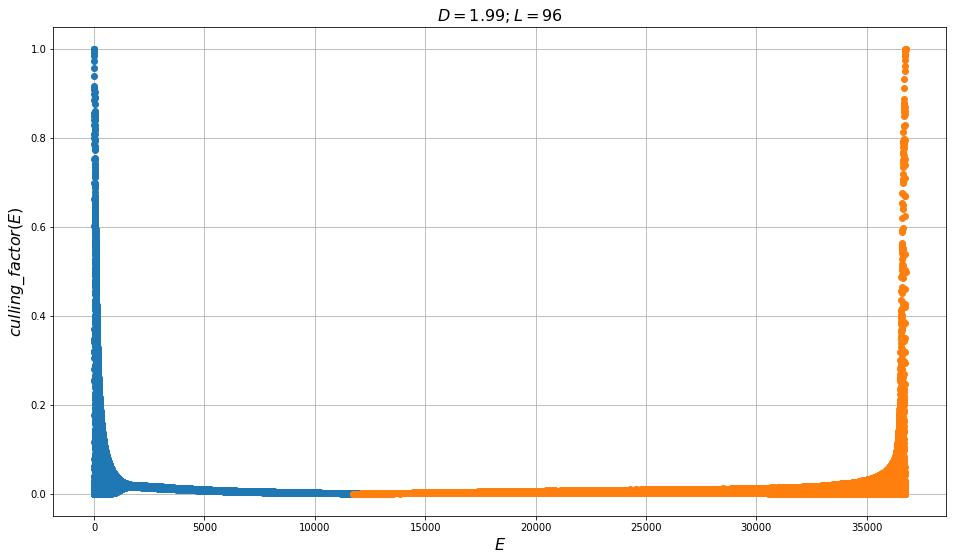

In [172]:
cool, heat, st = parameters[0]['cool'], parameters[0]['heat'], parameters[0]['stitched']

plt.figure(figsize=(16, 9))

plt.plot([x for x in cool['culling_factor']], [y for x, y in cool['culling_factor'].items()], 'o')
plt.plot([x for x in heat['culling_factor']], [y for x, y in heat['culling_factor'].items()], 'o')
plt.grid()

plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
plt.ylabel('$culling\_factor(E)$', fontsize=16)
plt.xlabel('$E$', fontsize=16)
plt.show()
#plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


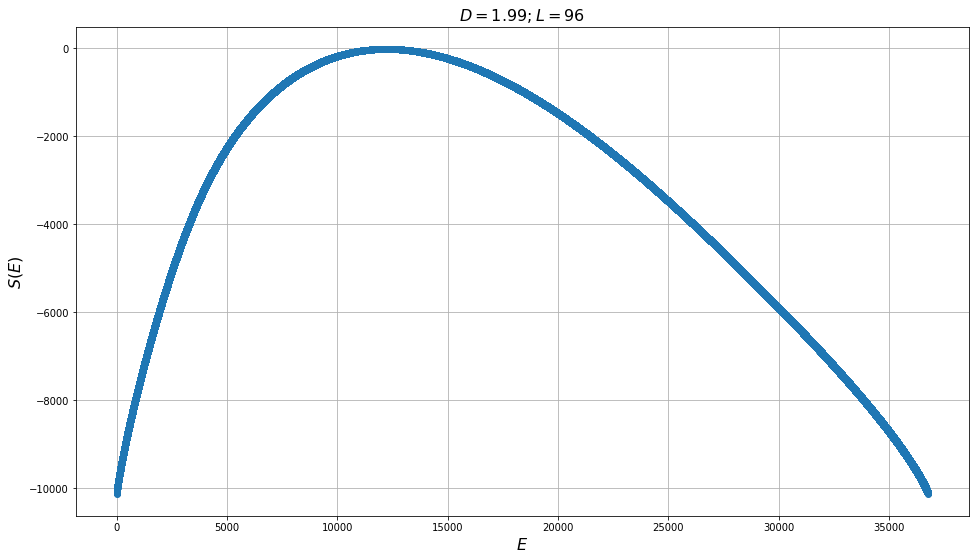

In [173]:
plt.figure(figsize=(16, 9))


plt.plot([x for x in st['S']], [y for x, y in st['S'].items()], 'o')
plt.grid()
plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
plt.ylabel('$S(E)$', fontsize=16)
plt.xlabel('$E$', fontsize=16)
#savefig("./images/S(E)_D{}_L{}.png".format(st["D"], st["L"]))
plt.show()

In [174]:
D

1.99

In [175]:


a = 0.3
b = 1.2

for x in parameters:
    st = x["stitched"]
    L = st["L"]
    t, c, _, _ = fminbound(lambda T: -calc_hc(st, T)[1], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }

print(T_crit)



{8: {'T_crit': 0.5655586045276617, 'C_crit': 1.311721381576917}, 12: {'T_crit': 0.5295490122150894, 'C_crit': 1.459501858273613}, 16: {'T_crit': 0.5028587144719773, 'C_crit': 1.6375079399434418}, 20: {'T_crit': 0.4969348913435719, 'C_crit': 2.0554781655022585}, 24: {'T_crit': 0.5613394000761336, 'C_crit': 1.1073548139559888}, 32: {'T_crit': 0.5525217152119772, 'C_crit': 1.112629879058696}, 48: {'T_crit': 0.5546367819887159, 'C_crit': 1.1010537689904778}, 64: {'T_crit': 0.5695906178150822, 'C_crit': 1.1005252616412973}, 96: {'T_crit': 0.5644824433222894, 'C_crit': 1.1198069534718667}}


In [176]:
with open('./tmp/T_crit_D{}00000.txt'.format(D), 'w') as f:
    json.dump(T_crit, f)

In [177]:
print('L & ' + ' & '.join([str(L) for L in T_crit]) + ' \\\\')
print('$T_{crit}$ & ' + ' & '.join([str(T_crit[L]['T_crit'])[:6] for L in T_crit]) + ' \\\\')
print('$C_{crit}$ & ' + ' & '.join([str(T_crit[L]['C_crit'])[:6] for L in T_crit]) + ' \\\\')

L & 8 & 12 & 16 & 20 & 24 & 32 & 48 & 64 & 96 \\
$T_{crit}$ & 0.5655 & 0.5295 & 0.5028 & 0.4969 & 0.5613 & 0.5525 & 0.5546 & 0.5695 & 0.5644 \\
$C_{crit}$ & 1.3117 & 1.4595 & 1.6375 & 2.0554 & 1.1073 & 1.1126 & 1.1010 & 1.1005 & 1.1198 \\


In [170]:
print('L & ' + ' & '.join([str(L) for L in T_crit]) + ' \\\\')

L & 8 & 12 & 16 & 20 & 24 & 32 & 48 & 64 \\


In [120]:
with open('./tmp/T_crit_D{}.txt'.format(D), 'r') as f:
    T_crit = json.load(f)

In [123]:
T_crit

{}

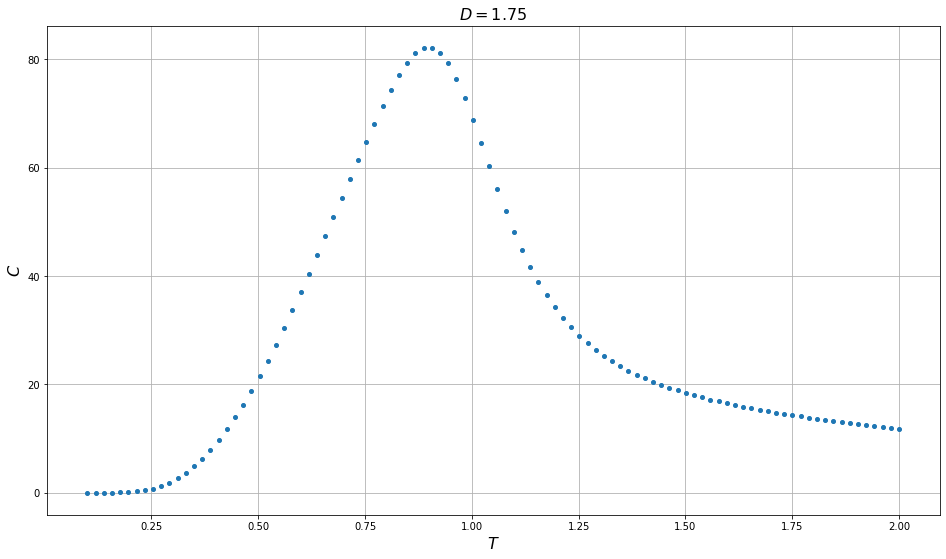

In [147]:
hc = {}
E = {}
BC = {}

for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L

    hc[L] = {}
    E[L] = {}
    BC[L] = {}


    T_list = np.linspace(0.1, 2.0, 100)
    

    # T, C, average E, BinderCumulant
    for T in tqdm(T_list):
        T, hc[L][T], E[L][T], BC[L][T] = calc_hc(st, T)


    plt.figure(figsize=(16, 9))


    plt.plot([float(T) for T in BC[st["L"]]], [bc for T, bc in hc[st["L"]].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$C$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)w
    plt.show()
    #plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


In [48]:
for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.87, 1.9, 1.92, 1.95, 1.962]):
    for L in tqdm([8, 12, 16, 20, 24, 32 48, 64]):
        cool, heat = [{
            "q": 3,
            "D": D,
            "L": L,
            "R" : 131072,
            "nSteps" : 10,
            "seed" : 0,
            "heat": False
        }], [{
            "q": 3,
            "D": D,
            "L": L,
            "R" : 131072,
            "nSteps" : 10,
            "seed" : 0,
            "heat": True
        }]
        print('D={}'.format(D))

        parameters = []
        for x in zip(cool, heat):
            try:
                parameters.append(read_tuple_files(x))
            except:
                pass
        for i, x in enumerate(tqdm(parameters)):
            parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
        print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))

        a = 0.5
        b = 2.0

        T_crit = {}
        for x in tqdm(parameters):
            st = x["stitched"]
            L = st["L"]
            t, c, _, _ = fminbound(lambda T: calc_hc(st, T)[3], a, b, maxfun=500, full_output=1, disp=False)
            T_crit[L] = {
                "T_crit": float(t),
                "BC_crit": float(-c / (L * L))
            }

        print(T_crit)

        #with open("./tmp/BC_crit_D{}.txt".format(D), 'w') as fp:
        #    for L in T_crit:
        #        fp.write('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['BC_crit']))

D=1.7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()



L in 8, 12, 16, 20, 24, 32, 48, 64



{8: {'T_crit': 0.8997000102968241, 'BC_crit': 0.001913845218095724}, 12: {'T_crit': 0.8945233494957207, 'BC_crit': 0.001024117261859618}, 16: {'T_crit': 0.8884446877668327, 'BC_crit': 0.00042617770142913854}, 20: {'T_crit': 0.8835937786506569, 'BC_crit': 0.00017874417777519614}, 24: {'T_crit': 0.8808014829277236, 'BC_crit': 0.0001012119981161728}, 32: {'T_crit': 0.8771318677982, 'BC_crit': 3.498610487813337e-05}, 48: {'T_crit': 0.8735246758421892, 'BC_crit': 1.2284986003110051e-05}, 64: {'T_crit': 0.8720304594384745, 'BC_crit': 3.1847576382048514e-06}}



In [3]:
T_crit = {}

In [10]:

D = 0.0
L = 8

cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
}]

parameters = []
for x in zip(cool, heat):
    try:
        parameters.append(read_tuple_files(x))
    except:
        pass
for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))
T_crit[L] = {}

a = 0.4
b = 2.0
c = 0.7

for x in parameters:
    st = x["stitched"]
    L = st["L"]
    t, bc, _, _ = fminbound(lambda T: - calc_hc(st, T)[3], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "BC_crit": float(bc)
    }

#for x in tqdm(parameters):
#    st = x["stitched"]
#    L = st["L"]
#    t, bc, _, _ = fminbound(lambda T: calc_hc(st, T)[3], b, c, maxfun=500, full_output=1, disp=False)
#    T_crit[L].update({
#        "T_crit_2": float(t),
#        "BC_crit_2": float(bc)
#    })

print(T_crit)
print('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['BC_crit']))
#print('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit_2'], T_crit[L]['BC_crit_2']))



/var/folders/0v/2xxng9410rl0ldw3shz9xrzw3cbqpn/T/ipykernel_21118/167725292.py:7: RuntimeWarning: divide by zero encountered in log
  sn += np.log(1 - c[E])
/var/folders/0v/2xxng9410rl0ldw3shz9xrzw3cbqpn/T/ipykernel_21118/167725292.py:16: RuntimeWarning: divide by zero encountered in log
  sn += np.log(1 - c[E])


L in 8
{8: {'T_crit': 1.999994105576493, 'BC_crit': 0.5130703383817576}}
8	1.999994105576493	0.5130703383817576



In [47]:
with open("./tmp/BC_crit_D{}.txt".format(D), 'w') as fp:
    for L in T_crit:
        fp.write('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['BC_crit']))

In [31]:
from magic_functions import calc_hc_tpl

In [4]:
T_crit = {}
C_crit = {}
for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87,
                        1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
                        1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
                        1.97, 1.99,
                        1.992]):
#D = 0.0
    T_crit[D] = {}
    C_crit[D] = {}
    with open("./tmp/T_crit_D{}.txt".format(D), 'r') as fp:
        for line in fp:
            L, T, C = line.split()
            T_crit[D][int(L)] = float(T)
            C_crit[D][int(L)] = float(C)

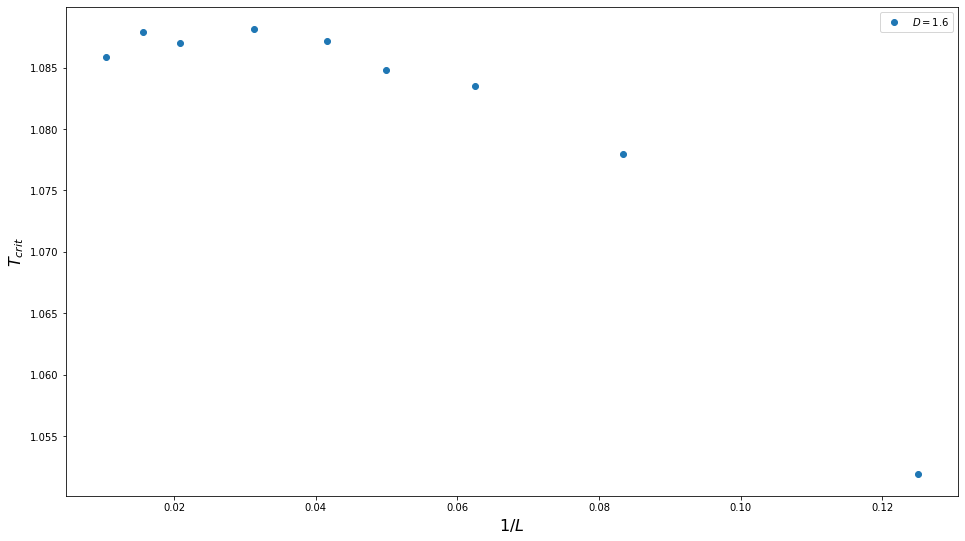

In [82]:
plt.figure(figsize=(16, 9))

D = 1.6
plt.plot([1/L for L in T_crit], [T_crit[L]['T_crit'] for L in T_crit], 'o', label="$D={}$".format(D))
#plt.yscale('log')
#plt.xscale('log')
#plt.title("$D={}$".format(D), fontsize=16)
plt.xlabel(r'$1/L$', fontsize=16)
plt.ylabel(r"$T_{crit}$", fontsize=16)
plt.legend()
#plt.grid(True, which="both")
plt.show()

(array([0.015625  , 0.00694444, 0.00390625, 0.0025    , 0.00173611,
        0.00097656, 0.00043403, 0.00024414, 0.00010851]),
 array([1.4088887 , 1.41137802, 1.41297188, 1.41008664, 1.41097004,
        1.40549362, 1.40495908, 1.40321056, 1.40282392]))

slope: 	-0.004890198743337357 +/-
	0.0005126887331833568
shift: 	0.4729281908706351 +/-
	0.0017292439457423441


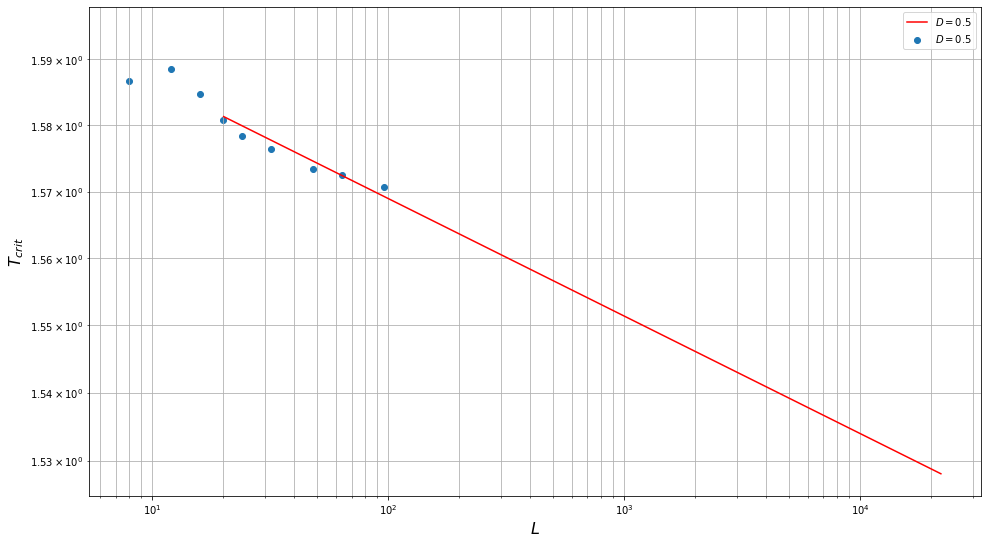

In [29]:
D = 0.5
x = np.array([L for L in T_crit[D].keys()])
y = np.array([T for L, T in T_crit[D].items()])

l = 0
fit = np.polyfit(np.log(x[l:]), np.log(y[l:]), 1, full=False)

plt.figure(figsize=(16, 9))

plt.scatter(x, y, label="$D={}$".format(D))

sample = np.linspace(3, 10, 20)
plt.plot(np.exp(sample), np.exp(fit[0] * sample + fit[1]), 'r', label="$D={}$".format(D))

plt.xlabel(r'$L$', fontsize=16)
plt.ylabel(r"$T_{crit}$", fontsize=16)
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both")
plt.legend()
#plt.savefig("./finite_size_D{}.png".format(D))

p, V = np.polyfit(np.log(x[l:]), np.log(y[l:]), 1, cov=True)

print("slope: \t{} +/-\n\t{}".format(p[0], np.sqrt(V[0][0])))
print("shift: \t{} +/-\n\t{}".format(p[1], np.sqrt(V[1][1])))
